# Sismique active S : Visualisation simple

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

import pandas as pd

from scipy import stats

import ipywidgets as widgets
from ipywidgets import interactive

/home/valentin/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from geometry import *

Text(0, 0.5, 'Northing (m)')

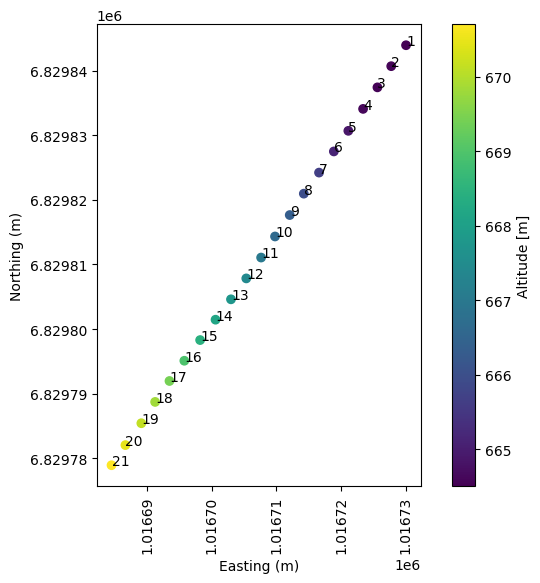

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for k, row in enumerate(gnss.iterrows()):
    k, serie = row
    plt.annotate(k, (serie[' Y '], serie[' X ']))
ax.set_aspect('equal', adjustable='box')

im = plt.scatter(gnss[' Y '], gnss[' X '], c=gnss['A'])
cb = plt.colorbar(im, label='Altitude [m]')

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=90)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

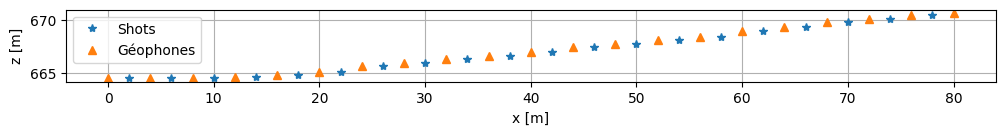

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
plt.plot(x_shots, y_shots, '*', label='Shots')
plt.plot(x_geophs, y_geophs, '^', label='Géophones')
plt.grid()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend()

## Min max

In [5]:
xy = np.loadtxt('data/sgt/positions.txt')
s = np.loadtxt('data/sgt/shots.txt', dtype=int)
g = np.loadtxt('data/sgt/geophones.txt', dtype=int)
t = np.loadtxt('data/sgt/times.txt')

In [6]:
def scatterplt(x_shot=12.75, geophones1=[0, -1], geophones2=[0, -1]):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    ax.scatter(x_shot, 0, c='red', marker='*')
    ax.scatter(x_geophs, [0]*len(x_geophs), c='green', marker='^')
    
    vs = [0, 0]
    interc = [0, 0]
    xcs = [0, 0]
    rs = [0, 0]
    geophones_ranges = (geophones1, geophones2)
    for k, geophones in enumerate(geophones_ranges):
        ii = np.where(xy[s-1][:, 0] == x_shot)
        x_geoph = xy[g[ii]-1][:, 0]
        times = t[ii]
        jj = np.where((x_geoph >= geophones[0]) & (x_geoph <= geophones[1]))
        xreg = x_geoph[jj]
        tslice = times[jj]
        slope, intercept, r, p, std_err = stats.linregress(xreg - x_shot, tslice)
        treg = slope * (xreg - x_shot) + intercept
        v = abs(1/slope)
        xc = (geophones[0] if slope > 0 else geophones[1]) - x_shot
        vs[k] = v
        interc[k] = intercept
        xcs[k] = xc
        rs[k] = r
        ax.scatter(x_geoph, times, c='black', marker='+')
        plt.axvline(geophones[0], linestyle=':', color='grey')
        plt.axvline(geophones[1], linestyle=':', color='grey')
        ax.plot(xreg, treg, label=f'v={v:.1f} m/s')
    
    k1, k2 = np.argsort(vs)
    v1, v2 = vs[k1], vs[k2]
    tintercept = interc[k2]
    xcross = xcs[k2]
    z = xcross/2*np.sqrt((v2-v1)/(v2+v1))
    print(f'v1={v1:.1f} m/s (r={rs[k1]:.3f}) v2={v2:.1f} (r={rs[k2]:.3f}) xcross={xcross:.1f} z={z:.3f} tinterc={tintercept:.3f}')
    print([geophones_ranges[k1], geophones_ranges[k2]])
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Traveltime [s]')
    ax.legend()
    ax.invert_yaxis()
    
    plt.show()

In [7]:
interactive_plot = interactive(scatterplt, x_shot=widgets.SelectionSlider(
    options=list(x_shots),
    value=x_shots[ns//2],
    description='Position du shot',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
), geophones1=widgets.IntRangeSlider(
    value=[x_geophs[0], x_geophs[ng//3]],
    min=np.min(x_geophs),
    max=np.max(x_geophs),
    step=dx,
    description='Geophones',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
), geophones2=widgets.IntRangeSlider(
    value=[x_geophs[2*ng//3], x_geophs[-1]],
    min=np.min(x_geophs),
    max=np.max(x_geophs),
    step=dx,
    description='Geophones',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
))
interactive_plot

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [8]:
slopes_ranges = np.loadtxt('data/modele_vitesses/slopes_ranges.txt') # fichier pointé à partir de l'outil interactif ci-dessus

In [9]:
vs = []
zs = []
intercepts = []
xcs = []
n_velocity = 4

for i, x_shot in enumerate(x_shots):

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    plt.title(f'Shot at {x_shot} m')
    ax.scatter(x_shot, 0, c='red', marker='*')
    ax.scatter(x_geophs, [0]*len(x_geophs), c='green', marker='^')

    v_layers = []
    interc_layers = []
    xc_layers = []
    
    for k in range(0, len(slopes_ranges[i]), 2):
        g1, g2 = slopes_ranges[i][k], slopes_ranges[i][k+1] # faire des paires de géophones
        if g1 == g2 == 0: # pas de pente
            continue
            
        ii = np.where(xy[s-1][:, 0] == x_shot)
        x_geoph = xy[g[ii]-1][:, 0]
        times = t[ii]
        jj = np.where((x_geoph >= g1) & (x_geoph <= g2))
        xreg = x_geophs[jj]
        tslice = times[jj]
        
        if len(tslice) == 1: # only 1 point, assume first layer and take source as second point
            slope = tslice[0]/(xreg[0] - x_shot)
            xreg = np.array([xreg[0], xreg[0]])
            intercept = 0
            xc = g1
        else:
            slope, intercept, r, p, std_err = stats.linregress(xreg - x_shot, tslice)
            xc = np.abs((g1 if slope > 0 else g2) - x_shot)
        
        treg = slope * (xreg - x_shot) + intercept
        v = abs(1/slope)
        v_layers.append(v)
        interc_layers.append(intercept)
        xc_layers.append(xc)

        #print(f'v={v} m/s intercept={intercept} r={r}')

        ax.scatter(x_geoph, times, c='black', marker='+')
        plt.axvline(g1, linestyle=':', color='grey')
        plt.axvline(g2, linestyle=':', color='grey')
        ax.plot(xreg, treg, label=f'v{(k//2)%n_velocity}={v:.1f} m/s')

    for j in range(n_velocity, len(v_layers)):
        v_layers[j-n_velocity] = (v_layers[j-n_velocity]+v_layers[j])/2
        interc_layers[j-n_velocity] = (interc_layers[j-n_velocity]+interc_layers[j])/2
        xc_layers[j-n_velocity] = (xc_layers[j-n_velocity]+xc_layers[j])/2
    v_layers = v_layers[:n_velocity]
    interc_layers = interc_layers[:n_velocity]
    xc_layers = xc_layers[:n_velocity]
    
    k_layers = np.argsort(v_layers)
    
    z_layers = []
    for i in range(len(k_layers)-1):
        v1, v2 = v_layers[k_layers[i]], v_layers[k_layers[i+1]] # arbitrary v1 and v2 to tell upper and lower layer
        xc = xc_layers[k_layers[i+1]]
        z = xc/2*np.sqrt((v2-v1)/(v2+v1))
        z_layers.append(z)
    
    vs.append(v_layers[:n_velocity])
    zs.append(z_layers[:n_velocity])
    xcs.append(xc_layers[:n_velocity])
    intercepts.append(interc_layers[:n_velocity])
    
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Traveltime [s]')
    ax.legend(loc='lower left')
    ax.invert_yaxis()
    fig.savefig(f'figures/velocity_slopes/slopes_shot_{x_shot:02d}.png')
    plt.close()

In [10]:
np.savetxt('data/modele_vitesses/vitesses.txt', vs)
np.savetxt('data/modele_vitesses/epaisseurs.txt', zs)
np.savetxt('data/modele_vitesses/xcross.txt', xcs)
np.savetxt('data/modele_vitesses/intercepts.txt', intercepts)

In [11]:
vs = np.loadtxt('data/modele_vitesses/vitesses.txt')
zs = np.loadtxt('data/modele_vitesses/epaisseurs.txt')
xcs = np.loadtxt('data/modele_vitesses/xcross.txt')
intercepts = np.loadtxt('data/modele_vitesses/intercepts.txt')

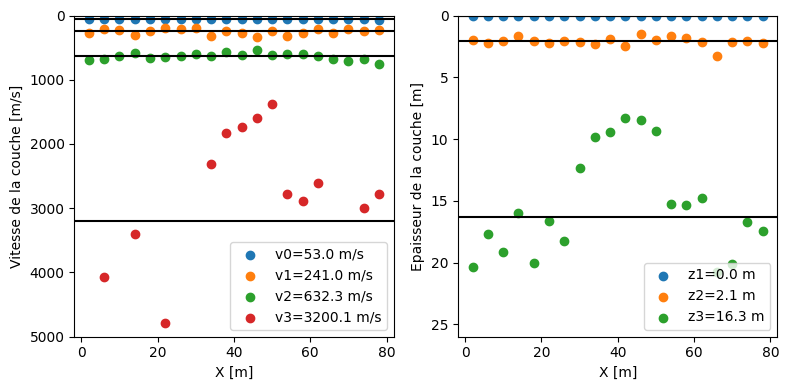

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
for k in range(n_velocity):
    v = np.median(vs[:, k])
    ax.axhline(v, c='k')
    ax.scatter(x_shots, vs[:, k], label=f'v{k}={v:.1f} m/s')
ax.set_ylim(5000, 0)
ax.set_ylabel('Vitesse de la couche [m/s]')
ax.set_xlabel('X [m]')
ax.legend(loc='lower right')

ax = axs[1]
for k in range(n_velocity-1):
    v = np.median(zs[:, k])
    ax.axhline(v, c='k')
    ax.scatter(x_shots, zs[:, k], label=f'z{k+1}={v:.1f} m')
ax.set_ylim(26, 0)
ax.set_ylabel('Epaisseur de la couche [m]')
ax.set_xlabel('X [m]')
ax.legend(loc='lower right')

fig.tight_layout()